In [4]:
!pip install scikit-image

     |████████████████████████████████| 14.0 MB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 210 kB 20.7 MB/s eta 0:00:01
     |████████████████████████████████| 34.5 MB 31.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 28.2 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 37.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.4 MB 23.4 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [5]:
import matplotlib.pyplot as plt
from skimage.draw import random_shapes
from skimage.measure import label    # See https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label
import tensorflow as tf
import numpy as np
#import h5py

#import sys
#sys.path.append("C:\\Users\\mha114\\Dropbox\\Python\\massimal\\tools")
    
#from segmentation import segmentation_data_generator

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

In [7]:
def segmentation_data_generator(n_images,
                                data_shape,
                                class_mean,
                                class_std = 0,
                                background_mean = 0,
                                background_std = 0,
                                min_size = 5,
                                max_size = None,
                                shape = 'ellipse'):
    """ Generate synthetic segmentation image data 
    
    # Input parameters:
    n_images:     Number of images to generate
    data_shape:   (n_rows, n_cols, n_channels)
    class_mean:   (class1_mean, class2_mean, ...)
                  Nested tuple wth mean value(s) for each class.
                  Each element contains mean values for all channels
    class_std:    (class1_mean, class2_mean, ...)
                  Nested tuple wth standard dev. value for each class.
                  Each element contains std values for all channels
                  If None, class_std is set to zero for each class
                  If non-zero, values for each class follow a Gaussian
                  distribution.
    min_size:     Minimum size (pixels) of each object
    max_size:     Maximum size of each object
    shape:        {rectangle, circle, triangle, ellipse, None} str, optional
                  Shape to generate, 'None' to pick random ones
    
    
    # Returns:
    image:        Image with dimensions (n_rows, n_cols, n_channels)
                  dtype = float64
    label         Image with dimensions (n_rows, n_cols)
                  dtype = int
                  Classes are labelled 1, 2, ... according to their
                  order in class_mean / class_std
                  Index 0 corresponds to "background" (no class)
                  
    # Notes:
    - Only generates a single object per class
    - This function relies heavily on the random_shapes function 
    from SciKit Image: https://scikit-image.org/docs/stable/api/skimage.draw.html#skimage.draw.random_shapes
    
    """
    
    n_rows, n_cols, n_channels = data_shape
    n_classes = len(class_mean)
    
    image_count = 0
    while image_count < n_images:
        # Make random shapes and label them, retrying if random_shapes() generates too few
        n_labels = None
        while n_labels != n_classes:
            # Generate random image with random intensities
            random_im, _ = random_shapes((n_rows,n_cols),
                                max_shapes=n_classes,
                                min_shapes=n_classes,
                                min_size=min_size,
                                max_size=max_size,
                                intensity_range=(0,127),
                                shape = shape,
                                num_trials=200,
                                channel_axis=None)
            # Label the random shapes (0=background, 1=first class, etc.)
            labels, n_labels = label(random_im,background=255,return_num=True)


        noise_generator = np.random.default_rng()
        

        im = np.zeros(data_shape)
        
        if background_mean != 0 or background_std != 0:
            background_mask = np.where(labels==0)
            if len(background_mean) == 1:
                background_mean = (background_mean for _ in range(data_shape[-1]))
            if len(background_std) == 1:
                background_std = (background_std for _ in range(data_shape[-1]))
                
            background_noise = noise_generator.multivariate_normal(
                mean=background_mean,cov=np.diag(background_std),size=background_mask[0].shape)
            im[background_mask] = background_noise
        
        for i in range(n_labels):
            class_mask = np.where(labels==(i+1))
            if len(class_std) == 1:
                class_std = (class_std for _ in range(data_shape[-1]))
            class_signal = noise_generator.multivariate_normal(
                mean=class_mean[i],cov=np.diag(class_std[i]),size=class_mask[0].shape)
            im[class_mask] = class_signal
            
        # Limit to [0,1] TODO: Maybe do this in a more general/flexible manner
        im[im<0] = 0
        im[im>1] = 1

        yield im, labels
        image_count += 1

In [8]:
# Generate and stack several images on top of each other
n_train_images=1000
n_val_images = 200
data_shape = (32,32,3)
class_mean = ((0.5,0.3,0.1),(0.1,0.3,0.5))
class_std = ((0.3,0.2,0.1),(0.1,0.2,0.3))
background_mean = (0.3, 0.3, 0.3)
background_std = (0.02,0.02,0.02)

train_data = np.zeros((n_train_images,)+data_shape,dtype=np.float32)
train_labels = np.zeros((n_train_images,)+data_shape[0:2],dtype=np.int8)
for i, data in enumerate(segmentation_data_generator(n_train_images,data_shape,class_mean,
                            class_std=class_std,background_mean=background_mean, background_std=background_std)):
    train_data[i] = data[0]
    train_labels[i] = data[1]

In [9]:
val_data = np.zeros((n_val_images,)+data_shape,dtype=np.float32)
val_labels = np.zeros((n_val_images,)+data_shape[0:2],dtype=np.int8)
for i, data in enumerate(segmentation_data_generator(n_val_images,data_shape,class_mean,
                            class_std=class_std,background_mean=background_mean, background_std=background_std)):
    val_data[i] = data[0]
    val_labels[i] = data[1]

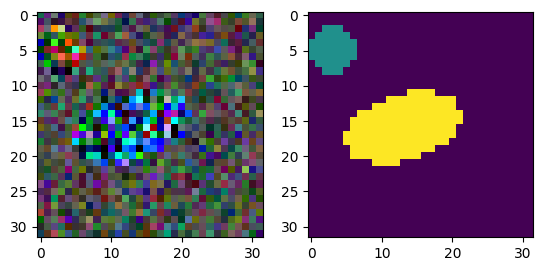

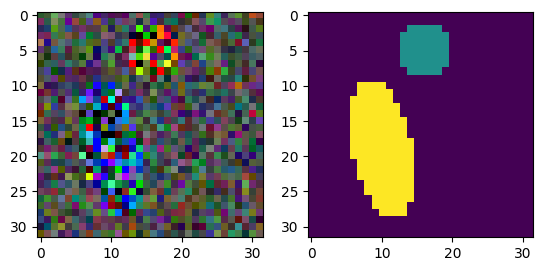

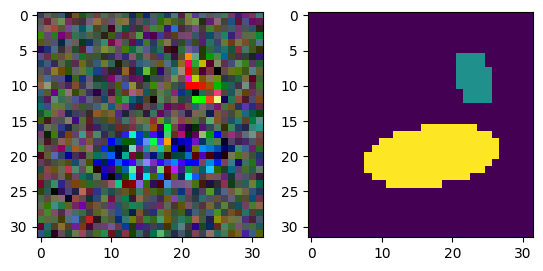

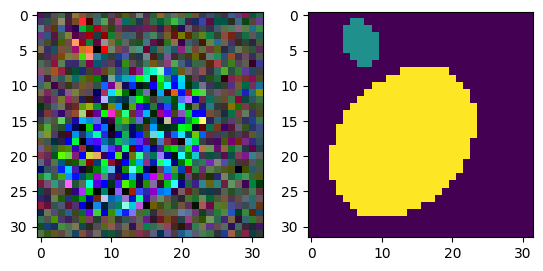

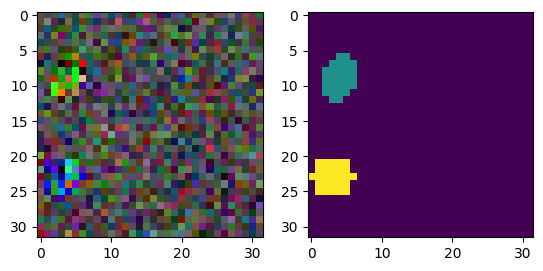

In [10]:
for i in range(5):
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(np.float32(train_data[i]))
    ax[1].imshow(train_labels[i])
    plt.show()

In [11]:
# Create tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels))

In [12]:
BATCH_SIZE = 8
train_batches = (
    train_dataset
    .batch(BATCH_SIZE))

val_batches = val_dataset.batch(BATCH_SIZE)

In [13]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([0.0, 1.0, 1.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [14]:
tmp = train_dataset.map(add_sample_weights)

In [15]:
# from https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter09_part01_image-segmentation.ipynb
def get_model(img_size, num_classes):
    #inputs = keras.Input(shape=img_size + (3,))
    #x = layers.Rescaling(1./255)(inputs)
    inputs = keras.Input(shape=img_size)

    # x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(inputs)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    #x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    #x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    #x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    #x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

In [16]:
model = get_model(img_size=data_shape, num_classes=3)
#model.summary()
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy",weighted_metrics=[])

callbacks = [
   # keras.callbacks.ModelCheckpoint("test_segmentation.keras",
   #                                 save_best_only=True)
]

# Weighting 
In order to give different weight to different labels, each pixel needs to be given a "sample weight". We basically need a "weight image" in the same way that we have a "label image". This is described in the TensorFlow documentation here: https://www.tensorflow.org/tutorials/images/segmentation#optional_imbalanced_classes_and_class_weights

In [17]:
# Code inspired by https://www.tensorflow.org/tutorials/images/segmentation#optional_imbalanced_classes_and_class_weights
history = model.fit(train_batches.map(add_sample_weights),
                    epochs=5,
                    validation_data=val_batches.map(add_sample_weights))
# history = model.fit(train_batches,
#                     epochs=15,
#                     validation_data=val_batches)

Epoch 1/5
125/125 [==============================] - 6s 13ms/step - loss: 0.0661 - val_loss: 0.0124
Epoch 2/5
125/125 [==============================] - 1s 11ms/step - loss: 0.0064 - val_loss: 6.3040e-04
Epoch 3/5
125/125 [==============================] - 2s 15ms/step - loss: 8.2650e-04 - val_loss: 6.6061e-04
Epoch 4/5
125/125 [==============================] - 2s 14ms/step - loss: 9.6452e-04 - val_loss: 6.3230e-04
Epoch 5/5
125/125 [==============================] - 1s 11ms/step - loss: 5.4274e-04 - val_loss: 5.9324e-04


In [67]:
# Code from DLWP book
# history = model.fit(train_data, train_labels,
#                     epochs=5,
#                     callbacks=callbacks,
#                     batch_size=8,
#                     validation_data=(val_data, val_labels))


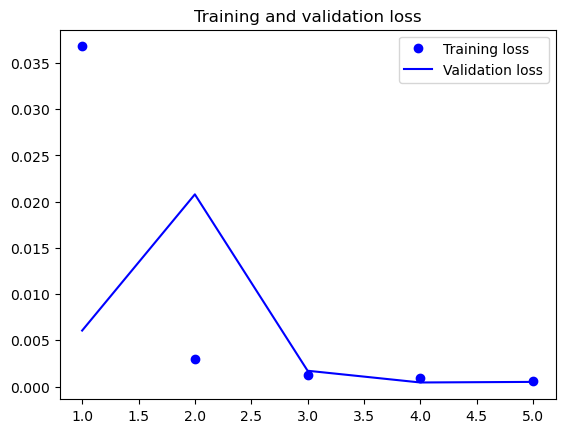

In [78]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
# Validation loss levels out after approx 7-8 epochs

In [79]:
predictions = model.predict(val_data)

7/7 [==============================] - 1s 37ms/step


In [62]:
# print(f'Example background: {predictions[0][20,20]}')
# print(f'Example blue class: {predictions[0][10,5]}')
# print(f'Example red class: {predictions[0][5,20]}')

Example background: [9.9999994e-01 5.7609147e-12 4.7730431e-12]
Example blue class: [1.0141613e-04 3.3434785e-07 9.9989814e-01]
Example red class: [1.3854557e-06 9.9999851e-01 1.6349715e-11]


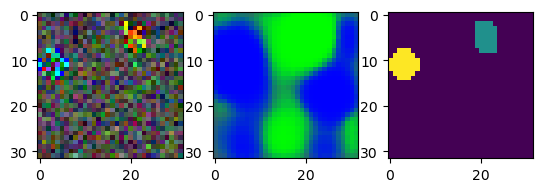

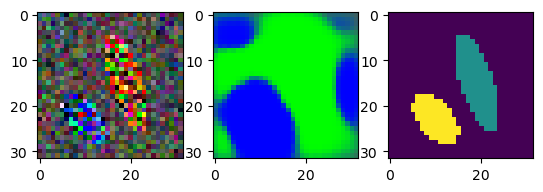

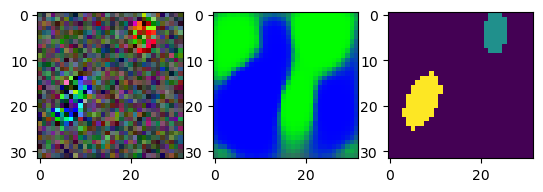

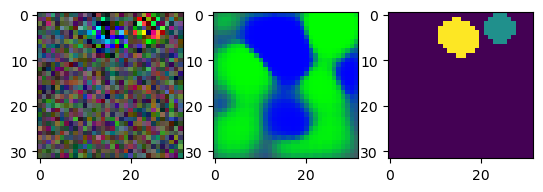

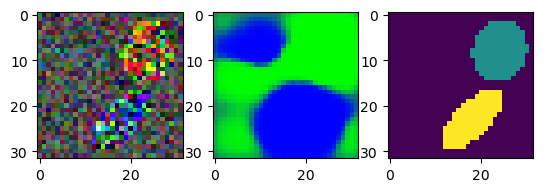

In [80]:
# Show "raw" probabilities from predictions
# Green corresponds to "red class" (label 1), blue corresponds to "blue class" (label 2)
# There are no clear boundaries (it's working as expected, I guess) 
for i in range(5):
    #mask = np.argmax(predictions[i], axis=-1)
    fig,ax = plt.subplots(1,3)
    ax[0].imshow(val_data[i])
    ax[1].imshow(predictions[i])
    ax[2].imshow(val_labels[i])

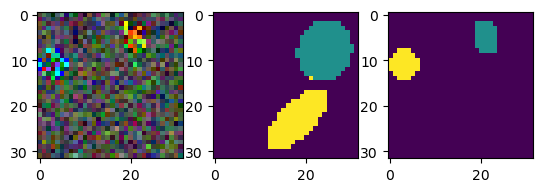

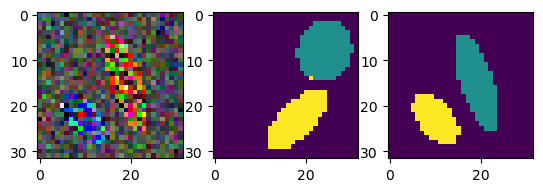

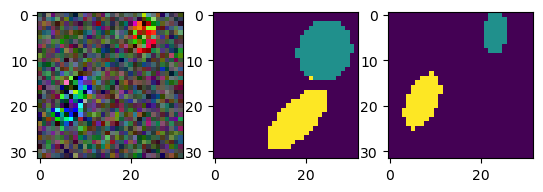

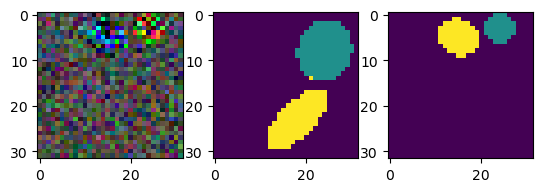

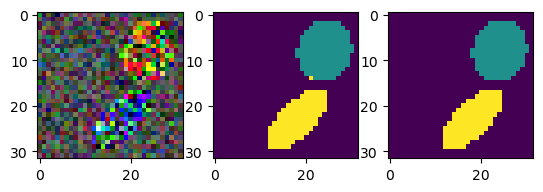

In [81]:
# Use backgruond masking to check if the two main classes are correctly classified
# Mostly correct!
for i in range(5):
    most_probable_class = np.argmax(predictions[i], axis=-1)
    most_probable_class[val_labels[i]==0] = 0
    fig,ax = plt.subplots(1,3)
    ax[0].imshow(val_data[i])
    ax[1].imshow(mask,vmin=0,vmax=2)
    ax[2].imshow(val_labels[i])